## Semi-supervised learing.

Данные и их предобработка - как предыдущем задании (USE + PCA, 20newsgroups).

In [83]:
import tensorflow_hub as hub

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Скопируем из 3 Д/З.
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Train
newsgroups_train = fetch_20newsgroups(subset='train')
embeddings = []

for t in tqdm(newsgroups_train.data):
    emb = embed([t])
    embeddings.append(emb.numpy())

vectors = np.concatenate(embeddings)
pca = PCA(n_components=None)
vectors_pca = pca.fit_transform(vectors)
n = sum(np.cumsum(pca.explained_variance_ratio_) < 0.95)
np.sum(pca.explained_variance_ratio_[:n+1])
vectors_pca = vectors_pca[:, :n+1]

# Test
newsgroups_test = fetch_20newsgroups(subset='test')
embeddings_test = []

for t in tqdm(newsgroups_test.data):
    emb = embed([t])
    embeddings_test.append(emb.numpy())

vectors_te = np.concatenate(embeddings_test)
vectors_pca_te = pca.transform(vectors_te)
vectors_pca_te = vectors_pca_te[:, :n+1]

100%|██████████| 7532/7532 [00:35<00:00, 214.38it/s]


### 1) Подготовка semi-supervised датасетов.

Подготовить 10 датасетов, где последовательно берется 10, 20 и тд до 100 процентов каждого класса в качестве размеченных данных, остальные (90, 80, ... 0) каждого класса использовать как неразмеченные.

In [9]:
# В словаре лежат 10 датасетов для обучения, где ключом является строка, обозначающая процентаж
# (например, '0.1' - 10% каждого класса размеченные данные), а в значениях словаря
# лежат соответствующие датасеты в виде словаря с ключами 'X' и 'y'.

train_dfs = {}

for labeled_pct in np.arange(0.1, 1, 0.1):
    
    X_lbl, X_unlbl, y_lbl, y_unlbl = train_test_split(
        vectors_pca,
        newsgroups_train.target,
        train_size=labeled_pct,
        stratify=newsgroups_train.target,
        random_state=42
        )
    X = np.concatenate([X_lbl, X_unlbl])
    # Для semi-supervised sklearn алгоритмов для неразмеченных данных таргет равен -1.
    y = np.concatenate([y_lbl, -1 * np.ones(y_unlbl.shape)])

    # Лейбл для обозначения датасета
    lbl_pct = str(round(labeled_pct, 1))
    
    train_dfs[lbl_pct] = {}
    train_dfs[lbl_pct]['X'] = X
    train_dfs[lbl_pct]['y'] = y

train_dfs['1.0'] = {}
train_dfs['1.0']['X'] = vectors_pca
train_dfs['1.0']['y'] = newsgroups_train.target

### 2) Обучение алгоритмов частичного обучения.

Применить LabelPropagation, LabelSpreading и self training подходы для решения задачи semisupervised learning, в качестве метрики выбрать accuracy.

In [12]:
%%time

# Метрики считаются на отложенном тесте, где есть реальная разметка.
metrics_lp = []
metrics_ls = []
metrics_st = []

for labeled_pct in tqdm(np.arange(0.1, 1.1, 0.1)):
    lbl_pct = str(round(labeled_pct, 1))
    X_train = train_dfs[lbl_pct]['X']
    y_train = train_dfs[lbl_pct]['y']

    label_prop_model = LabelPropagation(max_iter=2000)
    label_prop_model.fit(X_train, y_train)
    y_pred_lp = label_prop_model.predict(vectors_pca_te)
    metrics_lp.append(accuracy_score(newsgroups_test.target, y_pred_lp))

    label_spr_model = LabelSpreading(max_iter=1000)
    label_spr_model.fit(X_train, y_train)
    y_pred_ls = label_spr_model.predict(vectors_pca_te)
    metrics_ls.append(accuracy_score(newsgroups_test.target, y_pred_ls))

    self_train_model = SelfTrainingClassifier(base_estimator=LogisticRegression(), max_iter=1000)
    self_train_model.fit(X_train, y_train)
    y_pred_st = self_train_model.predict(vectors_pca_te)
    metrics_st.append(accuracy_score(newsgroups_test.target, y_pred_st))

100%|██████████| 10/10 [3:11:22<00:00, 1148.23s/it]

CPU times: user 5h 25min 48s, sys: 36min 37s, total: 6h 2min 26s
Wall time: 3h 11min 22s


### 3) Сравнение обученных алгоритмов частичного обучения.

Для каждого алгоритма построить зависимость accuracy от процентажа (10, 20, 30... per class), аппроксимировать эту зависимость линейной функцией Ax+b и найти коэффициенты для каждого алгоритма semisupervised learning (всего 3) коэф. A, выбрать максимальный - это и будет решение.

In [50]:
print(metrics_lp)

[0.6992830589484864, 0.7241104620286777, 0.7271640998406798, 0.7348645778013808, 0.7413701540095592, 0.7457514604354754, 0.7470791290493892, 0.7522570366436537, 0.7561072756240043, 0.7571694105151354]


In [51]:
print(metrics_ls)

[0.7030005310674455, 0.7295539033457249, 0.7336696760488582, 0.7392458842272969, 0.7433616569304302, 0.747344662772172, 0.7472118959107806, 0.7522570366436537, 0.7574349442379182, 0.7587626128518322]


In [52]:
print(metrics_st)

[0.6828199681359532, 0.7140201805629315, 0.72052575677111, 0.7251725969198088, 0.7323420074349443, 0.728890069038768, 0.7326075411577271, 0.7340679766330324, 0.7351301115241635, 0.7369888475836431]


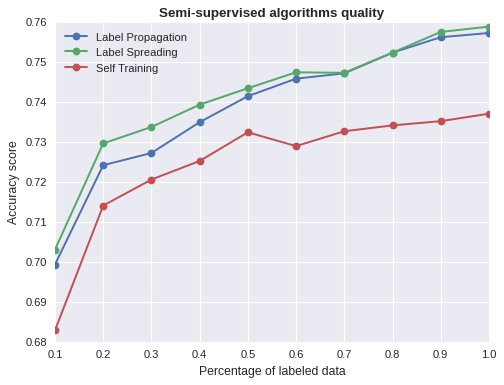

In [49]:
x = np.arange(0.1, 1.1, 0.1)

plt.style.use('seaborn')
plt.figure(figsize=(7, 5))
plt.plot(x, metrics_lp, marker='o', label='Label Propagation')
plt.plot(x, metrics_ls, marker='o', label='Label Spreading')
plt.plot(x, metrics_st, marker='o', label='Self Training')
plt.title('Semi-supervised algorithms quality', weight='bold')
plt.xlabel('Percentage of labeled data')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.grid(True);

In [75]:
# Обучим линейные регрессии полученных метрик accuracy в зависимости от процентажа (0.1, 0.2, ..., 1).
X = x.reshape(-1, 1)

lr_lp = LinearRegression()
lr_lp.fit(X, np.array(metrics_lp).reshape(-1, 1))
A_lp = lr_lp.coef_[0]
lp_pred = lr_lp.predict(X)

lr_ls = LinearRegression()
lr_ls.fit(X, np.array(metrics_ls).reshape(-1, 1))
A_ls = lr_ls.coef_[0]
ls_pred = lr_ls.predict(X)

lr_st = LinearRegression()
lr_st.fit(X, np.array(metrics_st).reshape(-1, 1))
A_st = lr_st.coef_[0]
st_pred = lr_st.predict(X)

In [86]:
A_list = [A_lp[0], A_ls[0], A_st[0]]
algorithms = ['Label Propagation', 'Label Spreading', 'Self Training']
print('The biggest coefficient A = {:.4f} of the algorithm {}.'.format(np.max(A_list), algorithms[np.argmax(A_list)]))

The biggest coefficient A = 0.0552 of the algorithm Label Propagation.


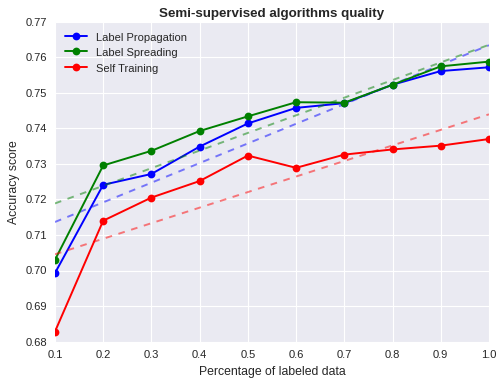

In [81]:
plt.figure(figsize=(7, 5))
plt.plot(x, metrics_lp, marker='o', label='Label Propagation', c='blue')
plt.plot(x, lp_pred, linestyle='dashed', c='blue', alpha=0.5)
plt.plot(x, metrics_ls, marker='o', label='Label Spreading', c='green')
plt.plot(x, ls_pred, linestyle='dashed', c='green', alpha=0.5)
plt.plot(x, metrics_st, marker='o', label='Self Training', c='red')
plt.plot(x, st_pred, linestyle='dashed', c='red', alpha=0.5)
plt.title('Semi-supervised algorithms quality', weight='bold')
plt.xlabel('Percentage of labeled data')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.grid(True);

In [87]:
pd.DataFrame([i for i in zip(algorithms, A_list)], columns=['Algorithm', 'Coefficient A'])

,Algorithm,Coefficient A
0,Label Propagation,0.055239
1,Label Spreading,0.049566
2,Self Training,0.043749


### 4) Описание полученных результатов.

Доп. пункты к оценке - обосновать и/или объяснить полученные минимальные и максимальные значения для коэф A в разрезе примененных алгоритмов.

**Для Label Propagation получился максимальный наклон, т.е. качество данного алгоритма растет быстрее с увеличением доли размеченных данных, чем у других рассматриваемых моделей. Для Self Training алгоритма наоборот: коэффициент наименьший, и по графику качества видно, что с определенной доли размеченных данных (около 50%), качество алгоритма не растет, а выходит на плато.**

Для **Self Training (ST)** алгоритма это связано с тем, что к размеченным данным в процессе обучения добавляются объекты с "псевдо-разметкой", на которых модель достаточно уверена (по умолчанию берутся объекты с вероятностью предсказания выше 0.75, т.е. на каждой итерации добавляются объекты только на наиболее уверенных предсказаниях). И если для маленького процентажа алгоритм ST еще сам достаточно много выучивает из данных и добавляется много информации именно с наиболее уверенных и "понятных" точек, то, когда процентаж уже выше, таких объектов меньше, и сам алгоритм ST не может быть также хорошо уверенным на них с точки зрения добавления в датасет новой "псевдо-разметки". В результате чего качество выходит на плато на более высоких процентажах и коэффициент А у данного алгоритма наименьший. (В данном случае число итераций для добавления в датасет новой "псевдо-разметки" достаточно высокое, поэтому частично выход на плато на больших процентажах можно объяснить также спецификой данных.)

Идея алгоритмов **Label Propagation (LP) и Label Spreading (LS)** состоит в том, что близкие объекты в терминах graph similarity принадлежат к одному классу. Изначально строится граф по имеющимся данным (в некотором смысле похоже на алгоритм спектральной кластеризации), где размеченные вершины графа являются абсорбирующими, и далее с помощью механизма случайных блужданий по графу итеративно обновляются лейблы для неразмеченных объектов. 

В алгоритме распространения меток (как LS, так и LP) по неразмеченным вершинам лейблы обновляются с помощью матрицы перехода P (transition matrix), которая считается как $D^{-1}A$ в случае propagation и $D^{-1/2}AD^{-1/2}$ в случае spreading, где $A$ - матрица смежности вершин графа, а $D$ - диагональная матрица со степенями вершин. Данная матрица перехода характеризует случайные блуждания по графу: их идея в том, что можно выделить кластеры там, где случайные блуждания дольше всего "задерживаются". Таким образом, чем выше процентаж абсорбируюих вершин, тем точнее можно рассчитать  матрицу перехода, и, следовательно, тем лучше можно распространить лейблы и понять, к какому классу относится неразмеченная нода. Чем меньше же размеченных вершин, тем ниже качество разметки вершин, находящихся на границе кластеров (на них выдаются "равномерные" вероятности принадлежности к классам и соответственно, качество классификации ниже). 

**Отличие LS от LP** в том, что первый алгоритм использует регуляризацию при поиске лучшего класса, т.е. Label Spreading является модификацией Label Propagation. Поэтому по этим двум алгоритмам можно делать одинаковые выводы с той оговоркой, что Label Spreading в общем случае работает немного лучше, т.к. использует регуляризацию (использует нормализованный Лапласиан графа). Это также видно из графика качества алгоритмов: при небольшой доле размеченных данных LS показывает выше долю правильных ответов, чем LP. Следовательно, лучше применять алгоритм с регуляризацией. Данное различие объясняет и полученные коэффициенты А. А ниже для LS, чем для LP, т.к. в LS нормализуем Лапласиан и не учитываем так сильно все метки, как в LP, когда размеченных данных становится много (более 50%).

В целом, следует заметить, что для всех алгоритмов качество увеличивается с долей размеченных данных и практически все алгоритмы заметно дольше обучались на данных с меньшим количеством размеченных данных, чем на датасетах с большим количеством разметки. Это можно связать с тем, что с разметкой качество алгоритмов в любом случае будет выше, т.к. передаем важную информацию алгоритму в явном виде.